# Check what the signal looks like

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# initial some global parameters
rep_inuse = 18
static_end = 5413137

### Import signals and labels

In [4]:
s101 = pd.read_csv('emg.csv', header = None)
label = pd.read_csv('grasp.csv', header = None)
position = pd.read_csv('position.csv', header = None)

s101_video1 = s101.iloc[0:static_end]
label_video1 = label.iloc[0:static_end]
position_video1 = position.iloc[0:static_end]

In [5]:
# find where the standing gestures are
standing = []
for i in tqdm(range(len(s101_video1))):
    if position_video1.iloc[i,0] == 1:
        standing.append(i)

In [6]:
# remove standing gestures
s101_static = s101_video1.drop(standing).reset_index(drop=True)
label_static = label_video1.drop(standing).reset_index(drop=True)

In [7]:
s101_static.info()
label_static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267633 entries, 0 to 3267632
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
dtypes: float64(12)
memory usage: 299.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267633 entries, 0 to 3267632
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 24.9 MB


## Plot signals and labels

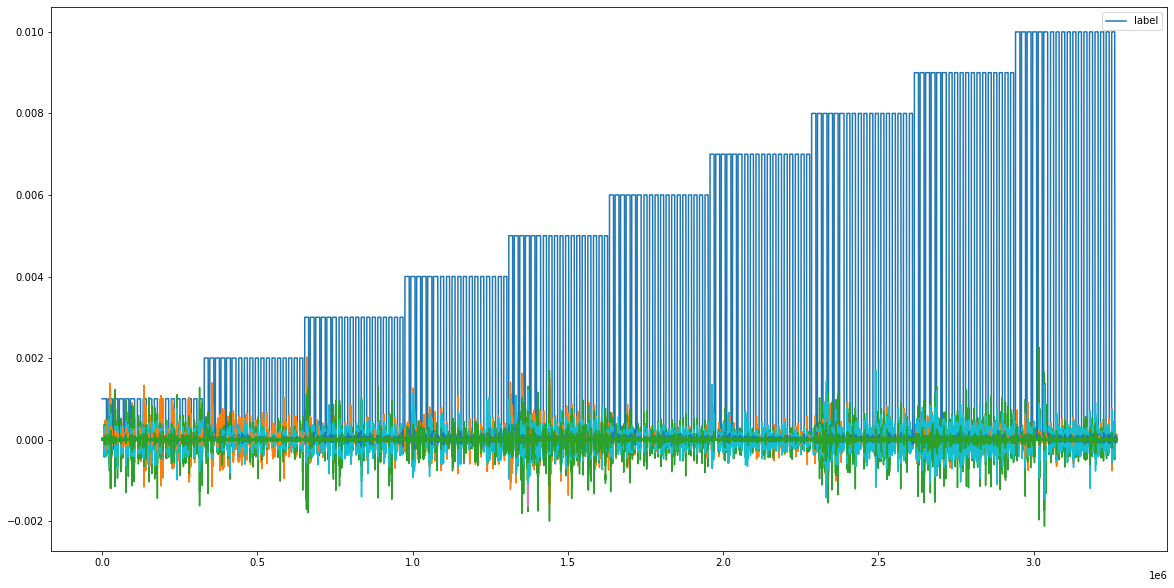

In [8]:
index = np.array(s101_static.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_static*0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_static[i])
    
line1.set_label('label')
ax.legend()
plt.show()

## Choose the first rep_inuse repetition of each grasp gesture,
## Combine them to a new data frame -- s101_rep_inuse

In [9]:
# find the ten start point
counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point = []
for i in label_number:
    for j in tqdm(range(0, len(label_static))):
        if label_static.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point.append(j)
        if counter == 10:
            break

In [10]:
# find the ten end point
last = 1
ten_end_point = []
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point[j-1], len(label_static))):
        if i == len(s101_static)-1:
            ten_end_point.append(i)
        current = label_static.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == rep_inuse*2:
            ten_end_point.append(i-1)
            break

In [11]:
ten_start_point
ten_end_point

[0,
 328982,
 652534,
 975247,
 1309744,
 1634027,
 1957937,
 2284986,
 2616010,
 2941777]

[328981,
 652533,
 975246,
 1309743,
 1634026,
 1957936,
 2284985,
 2616009,
 2941776,
 3267632]

In [12]:
a = 0
for i in range(0,10):
    a += ten_end_point[i] - ten_start_point[i] + 1
    
a

3267633

In [13]:
# get new signals
s101_rep_inuse = s101_static.iloc[ten_start_point[0]:ten_end_point[0] + 1,:]
for i in range(1,10):
    s101_rep_inuse = s101_rep_inuse.append(s101_static.iloc[ten_start_point[i]:ten_end_point[i] + 1,:])
s101_rep_inuse

,0,1,2,3,4,5,6,7,8,9,10,11
0,-5.004000e-07,1.496400e-06,-1.412200e-05,6.068300e-06,-0.000005,9.756200e-07,5.053400e-07,1.868200e-08,-1.901900e-06,0.000031,8.900800e-07,6.521500e-06
1,1.707100e-07,3.342700e-06,-1.378700e-05,2.711200e-06,-0.000008,1.143500e-06,2.687500e-06,1.871000e-08,-1.566300e-06,0.000023,2.568800e-06,4.795300e-06
2,8.418200e-07,4.014000e-06,-1.261200e-05,-3.163600e-06,-0.000008,3.829100e-06,2.519900e-06,1.873700e-08,-3.077100e-06,0.000012,-1.165600e-07,1.684000e-06
3,1.177200e-06,3.211200e-07,-8.583100e-06,-3.499500e-06,-0.000005,4.500500e-06,5.059100e-07,-1.490900e-07,-4.755600e-06,0.000004,-2.466200e-06,-7.056700e-07
4,3.377400e-07,-1.021800e-06,-4.219000e-06,-1.821100e-06,-0.000003,1.143600e-06,-1.508100e-06,1.879300e-08,-3.748700e-06,0.000002,-3.976600e-06,-5.694100e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
3267628,8.185200e-07,-3.948700e-06,-2.623300e-06,5.337000e-07,-0.000001,-2.999500e-06,2.295100e-06,-9.790200e-08,6.576600e-06,-0.000014,-1.636400e-06,3.407300e-06
3267629,-3.545600e-06,-4.452300e-06,6.233800e-08,4.058500e-06,-0.000001,-4.006600e-06,1.120200e-06,-9.790800e-08,4.730200e-06,-0.000037,-9.648700e-07,4.463200e-06
3267630,-8.581000e-06,-2.270100e-06,-1.616100e-06,7.079700e-06,-0.000001,-4.677900e-06,-7.259700e-07,-9.791500e-08,-6.410500e-07,-0.000044,-2.643200e-06,5.078000e-06
3267631,-1.093100e-05,3.101100e-06,-2.119700e-06,7.247500e-06,-0.000001,-4.342100e-06,-2.068700e-06,-9.792100e-08,-2.655300e-06,-0.000029,-5.328700e-06,3.079000e-06


In [14]:
# get new labels
label_rep_inuse = label_static.iloc[ten_start_point[0]:ten_end_point[0] + 1,:]
for i in range(1,10):
    label_rep_inuse = label_rep_inuse.append(label_static.iloc[ten_start_point[i]:ten_end_point[i] + 1,:])
label_rep_inuse

,0
0,1
1,1
2,1
3,1
4,1
...,...
3267628,0
3267629,0
3267630,0
3267631,0


## Plot the new signals and labels

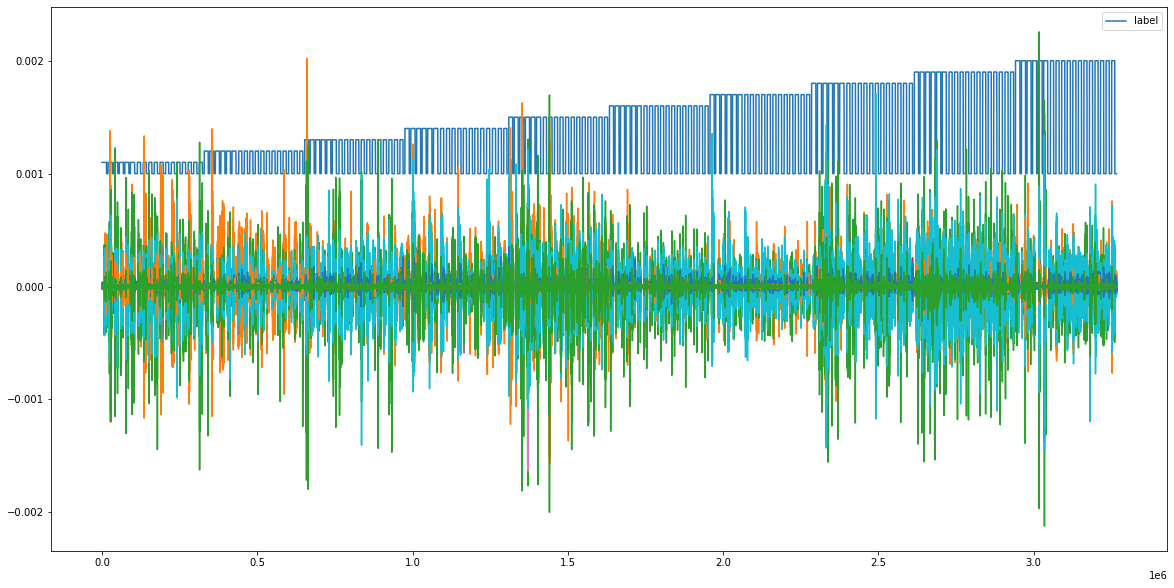

In [15]:
index = np.array(s101_rep_inuse.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse[i])
    
line1.set_label('label')
ax.legend()
plt.show()

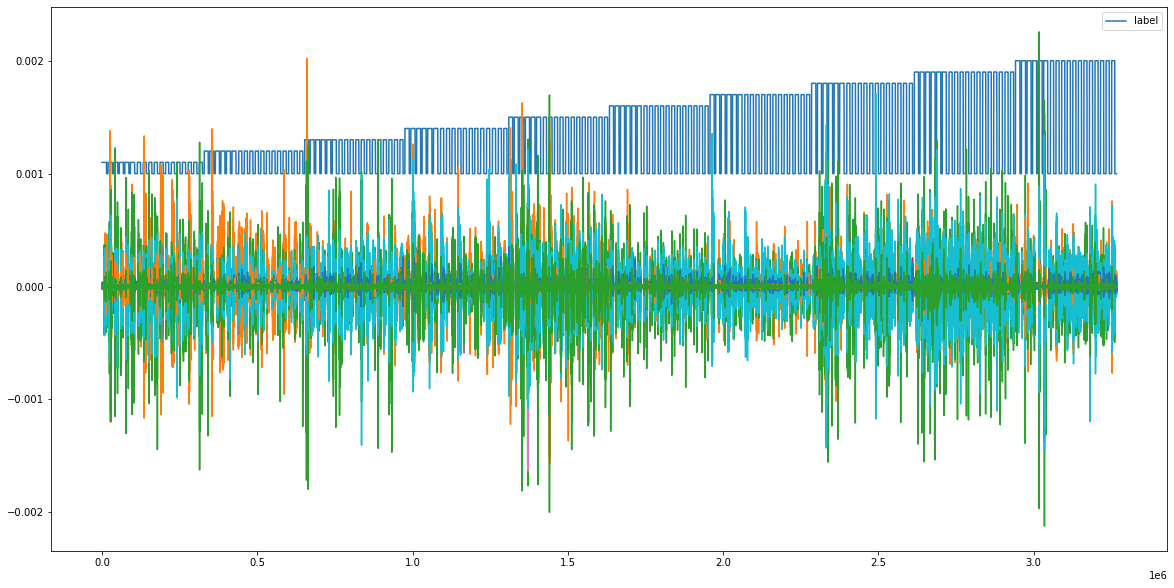

In [16]:
s101_rep_inuse = s101_rep_inuse.reset_index(drop = True)
label_rep_inuse = label_rep_inuse.reset_index(drop= True)

index = np.array(s101_rep_inuse.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The first rep_inuse repetition

In [17]:
# get the first gesture of new signals
s101_rep_inuse_first = s101_static.iloc[ten_start_point[0]:ten_end_point[0] + 1,:]

In [18]:
# get the first gesture of new labels
label_rep_inuse_first = label_static.iloc[ten_start_point[0]:ten_end_point[0] + 1,:]

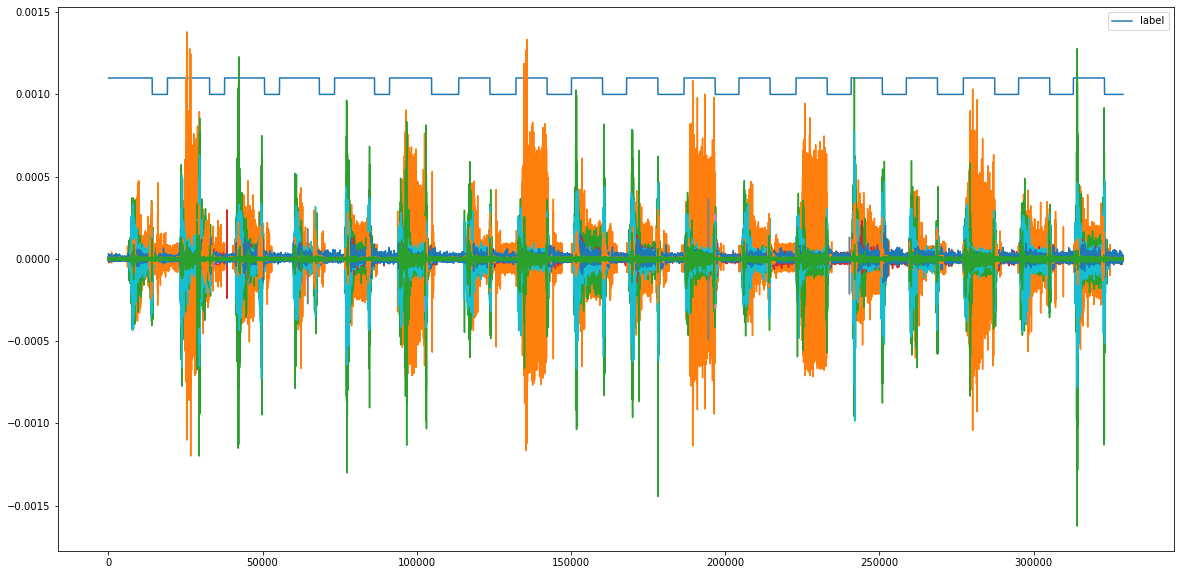

In [19]:
s101_rep_inuse_first = s101_rep_inuse_first.reset_index(drop = True)
label_rep_inuse_first = label_rep_inuse_first.reset_index(drop= True)

index = np.array(s101_rep_inuse_first.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_first*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_first[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The second rep_inuse repetition

In [20]:
# get the second gesture of new signals
s101_rep_inuse_second = s101_static.iloc[ten_start_point[1]:ten_end_point[1] + 1,:]

In [21]:
# get the second gesture of new labels
label_rep_inuse_second = label_static.iloc[ten_start_point[1]:ten_end_point[1] + 1,:]

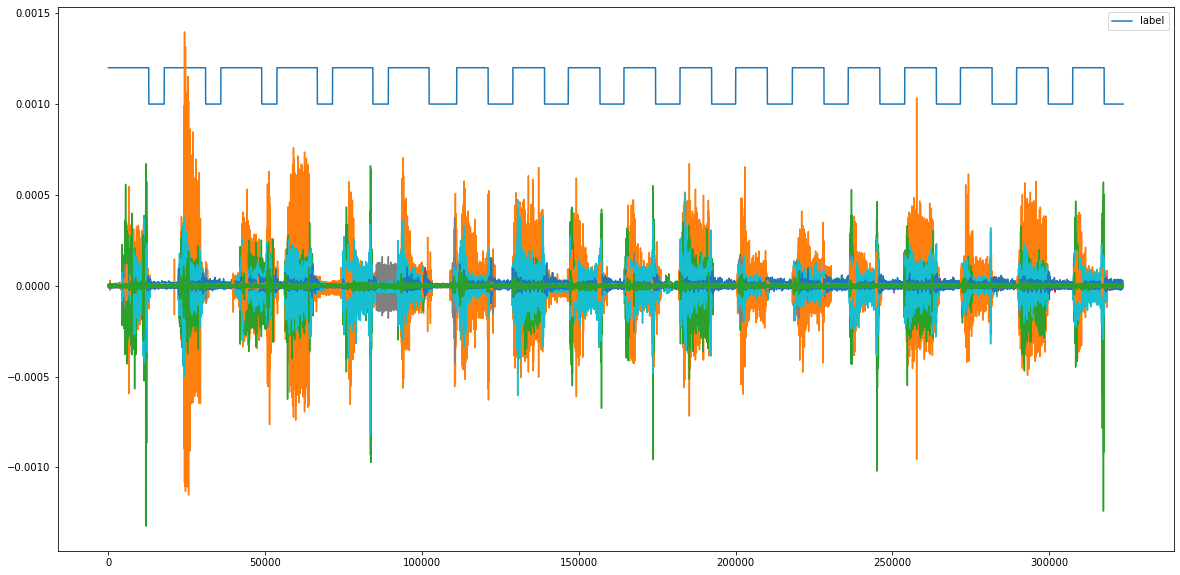

In [22]:
s101_rep_inuse_second = s101_rep_inuse_second.reset_index(drop = True)
label_rep_inuse_second = label_rep_inuse_second.reset_index(drop= True)

index = np.array(s101_rep_inuse_second.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_second*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_second[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The third rep_inuse repetition

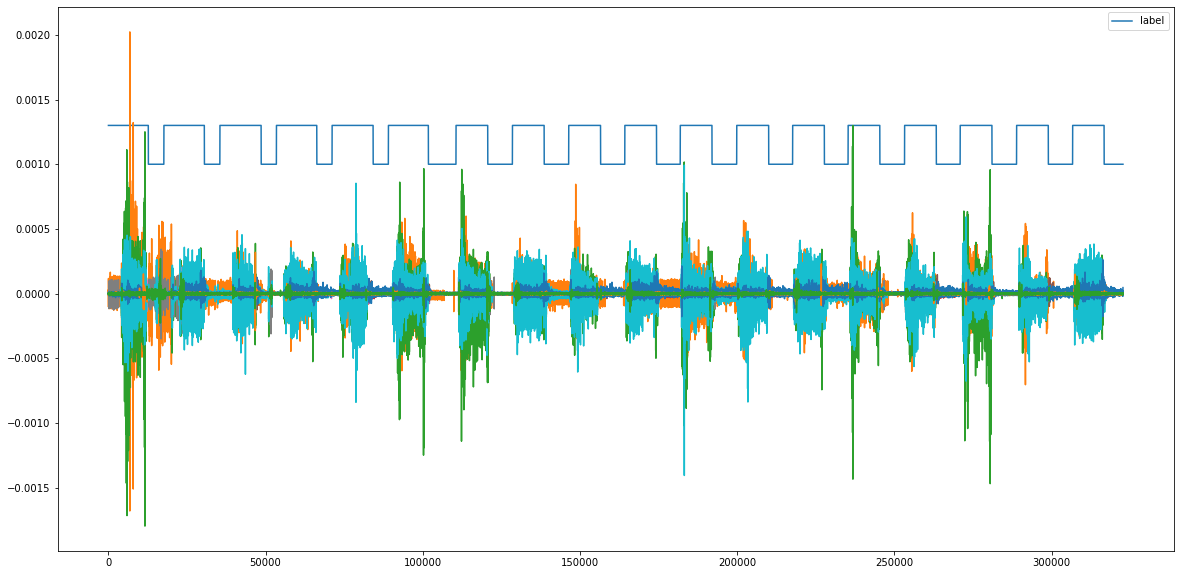

In [23]:
# get the third gesture of new signals
s101_rep_inuse_third = s101_static.iloc[ten_start_point[2]:ten_end_point[2] + 1,:]

# get the third gesture of new labels
label_rep_inuse_third = label_static.iloc[ten_start_point[2]:ten_end_point[2] + 1,:]

s101_rep_inuse_third = s101_rep_inuse_third.reset_index(drop = True)
label_rep_inuse_third = label_rep_inuse_third.reset_index(drop= True)

index = np.array(s101_rep_inuse_third.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_third*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_third[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The fourth rep_inuse repetition

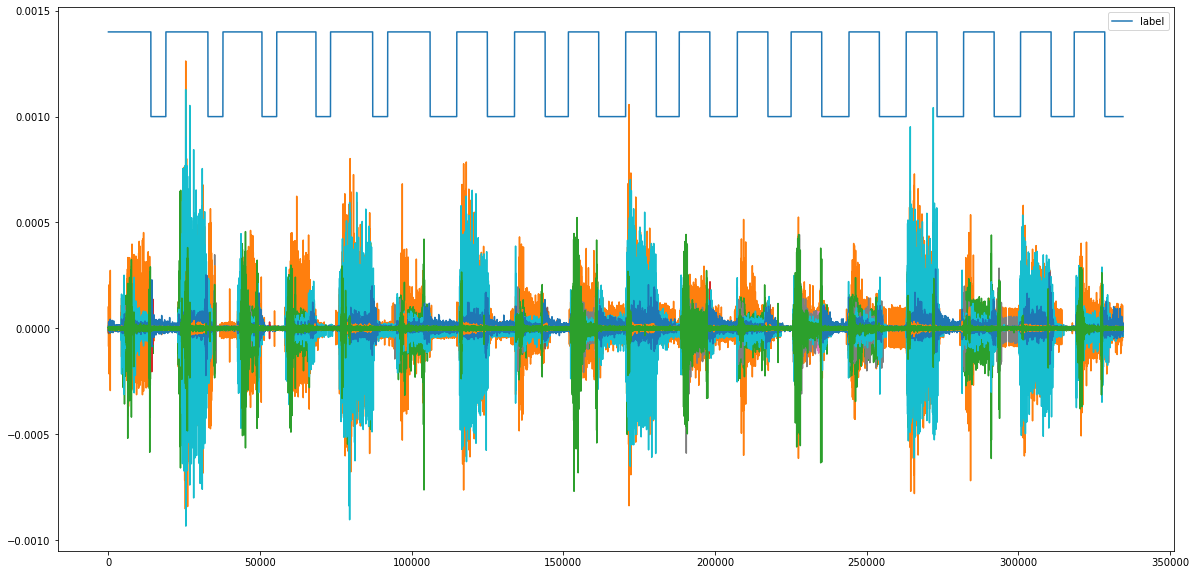

In [24]:
# get the fourth gesture of new signals
s101_rep_inuse_fourth = s101_static.iloc[ten_start_point[3]:ten_end_point[3] + 1,:]

# get the fourth gesture of new labels
label_rep_inuse_fourth = label_static.iloc[ten_start_point[3]:ten_end_point[3] + 1,:]

s101_rep_inuse_fourth = s101_rep_inuse_fourth.reset_index(drop = True)
label_rep_inuse_fourth = label_rep_inuse_fourth.reset_index(drop= True)

index = np.array(s101_rep_inuse_fourth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_fourth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_fourth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The fifth rep_inuse repetition

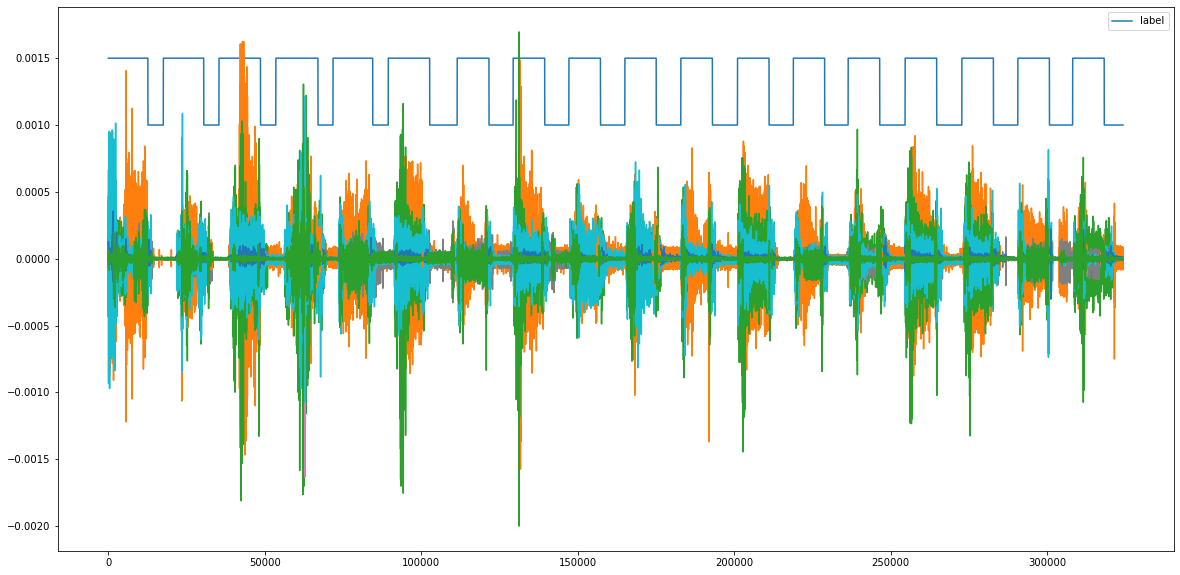

In [25]:
# get the fifth gesture of new signals
s101_rep_inuse_fifth = s101_static.iloc[ten_start_point[4]:ten_end_point[4] + 1,:]

# get the fifth gesture of new labels
label_rep_inuse_fifth = label_static.iloc[ten_start_point[4]:ten_end_point[4] + 1,:]

s101_rep_inuse_fifth = s101_rep_inuse_fifth.reset_index(drop = True)
label_rep_inuse_fifth = label_rep_inuse_fifth.reset_index(drop= True)

index = np.array(s101_rep_inuse_fifth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_fifth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_fifth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The sixth rep_inuse repetition

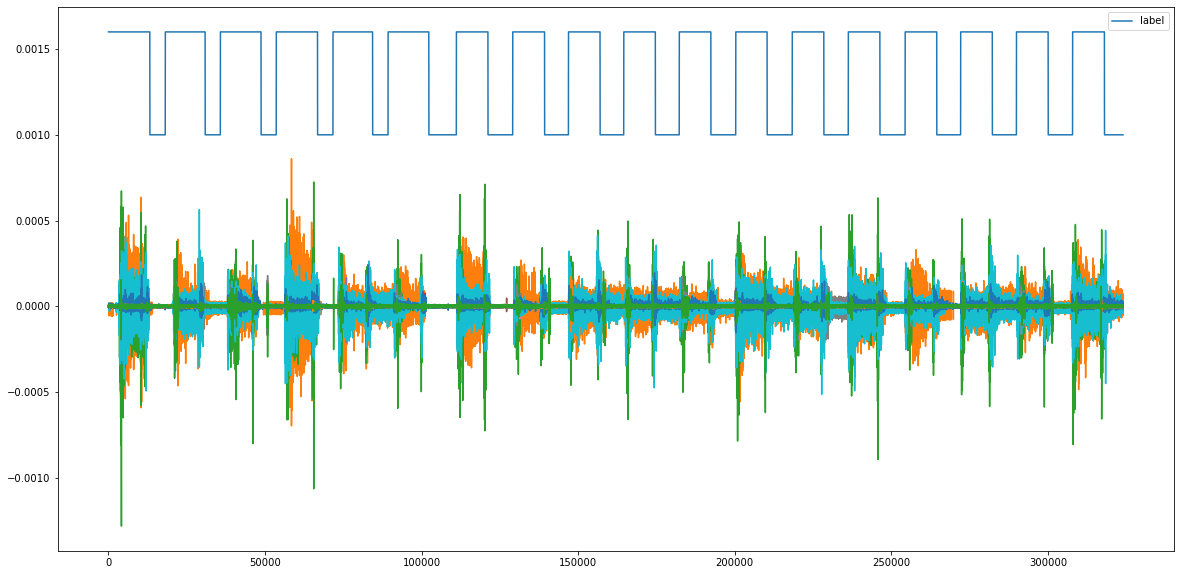

In [26]:
# get the sixth gesture of new signals
s101_rep_inuse_sixth = s101_static.iloc[ten_start_point[5]:ten_end_point[5] + 1,:]

# get the sixth gesture of new labels
label_rep_inuse_sixth = label_static.iloc[ten_start_point[5]:ten_end_point[5] + 1,:]

s101_rep_inuse_sixth = s101_rep_inuse_sixth.reset_index(drop = True)
label_rep_inuse_sixth = label_rep_inuse_sixth.reset_index(drop= True)

index = np.array(s101_rep_inuse_sixth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_sixth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_sixth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The seventh rep_inuse repetition

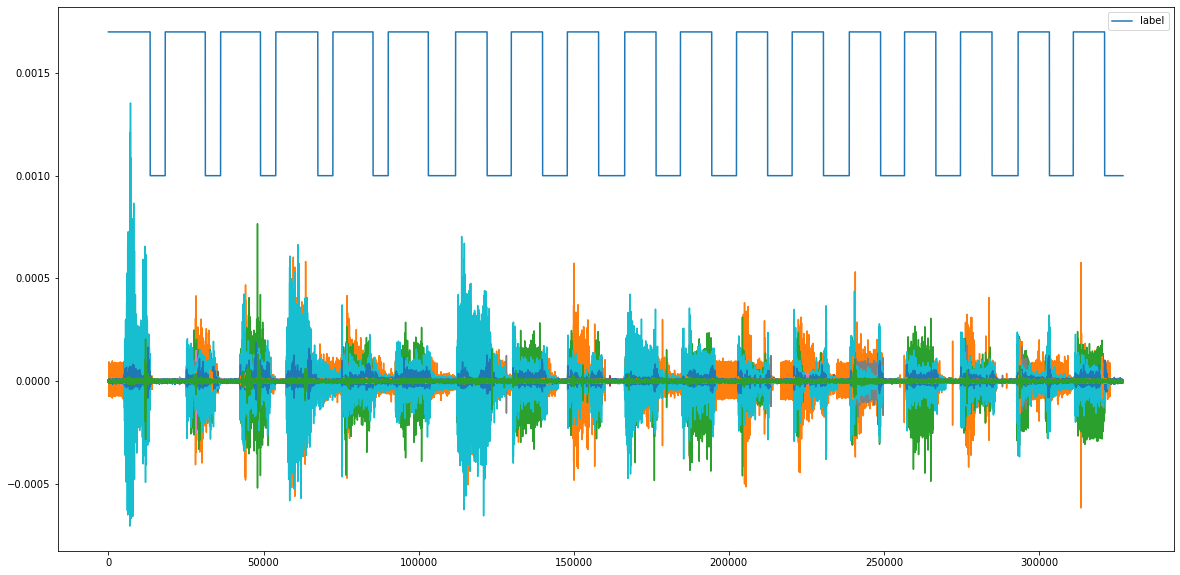

In [27]:
# get the seventh gesture of new signals
s101_rep_inuse_seventh = s101_static.iloc[ten_start_point[6]:ten_end_point[6] + 1,:]

# get the seventh gesture of new labels
label_rep_inuse_seventh = label_static.iloc[ten_start_point[6]:ten_end_point[6] + 1,:]

s101_rep_inuse_seventh = s101_rep_inuse_seventh.reset_index(drop = True)
label_rep_inuse_seventh = label_rep_inuse_seventh.reset_index(drop= True)

index = np.array(s101_rep_inuse_seventh.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_seventh*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_seventh[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The eighth rep_inuse repetition

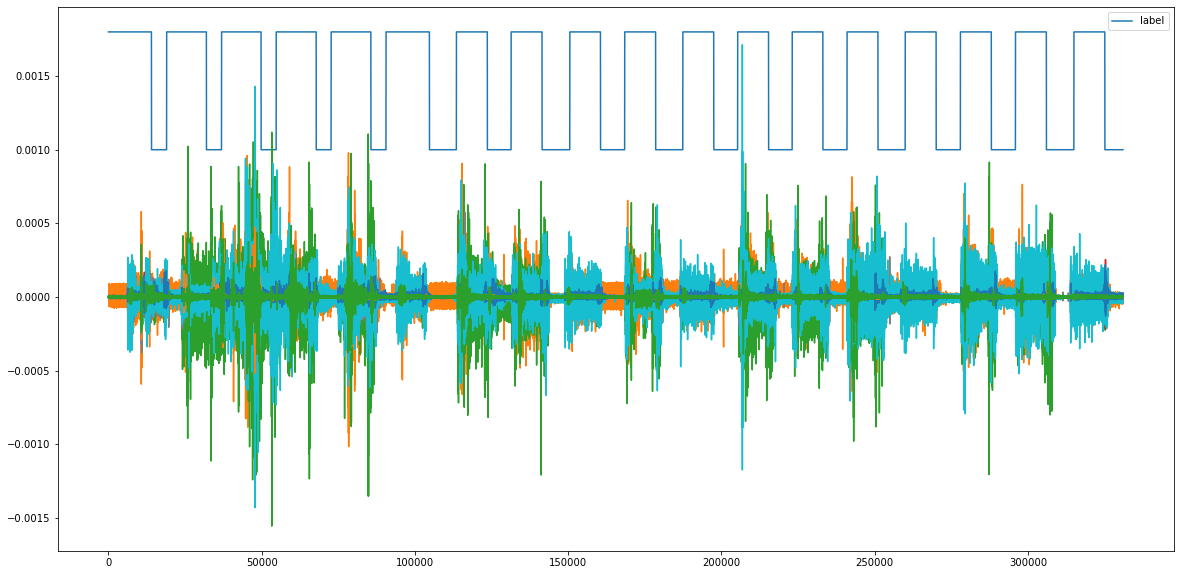

In [28]:
# get the eighth gesture of new signals
s101_rep_inuse_eighth = s101_static.iloc[ten_start_point[7]:ten_end_point[7] + 1,:]

# get the eighth gesture of new labels
label_rep_inuse_eighth = label_static.iloc[ten_start_point[7]:ten_end_point[7] + 1,:]

s101_rep_inuse_eighth = s101_rep_inuse_eighth.reset_index(drop = True)
label_rep_inuse_eighth = label_rep_inuse_eighth.reset_index(drop= True)

index = np.array(s101_rep_inuse_eighth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_eighth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_eighth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The nineth rep_inuse repetition

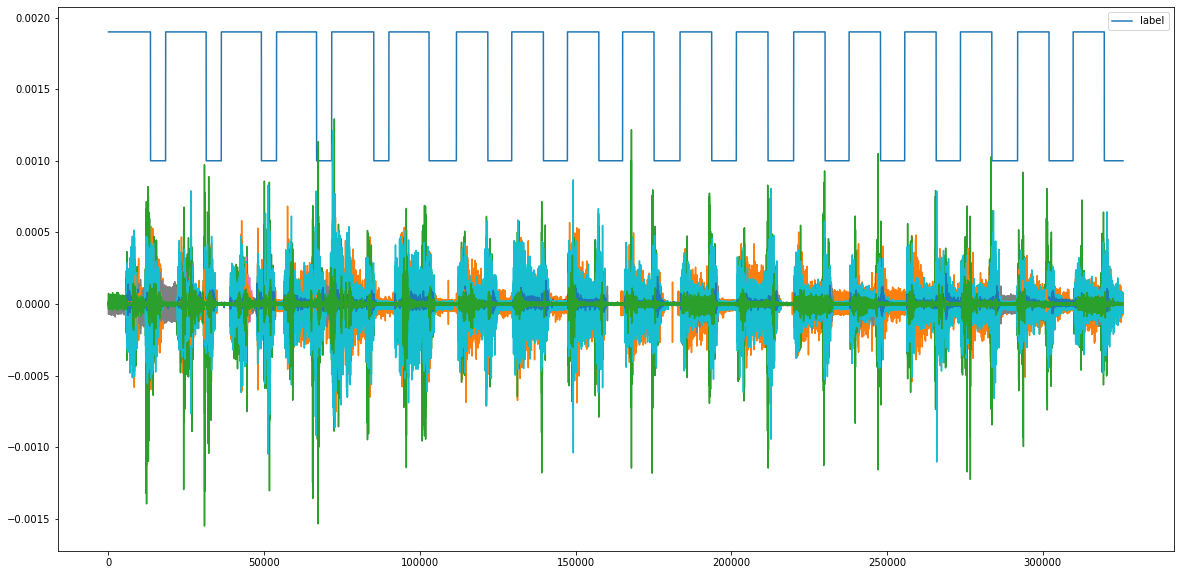

In [29]:
# get the nineth gesture of new signals
s101_rep_inuse_nineth = s101_static.iloc[ten_start_point[8]:ten_end_point[8] + 1,:]

# get the nineth gesture of new labels
label_rep_inuse_nineth = label_static.iloc[ten_start_point[8]:ten_end_point[8] + 1,:]

s101_rep_inuse_nineth = s101_rep_inuse_nineth.reset_index(drop = True)
label_rep_inuse_nineth = label_rep_inuse_nineth.reset_index(drop= True)

index = np.array(s101_rep_inuse_nineth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_nineth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_nineth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### The tenth rep_inuse repetition

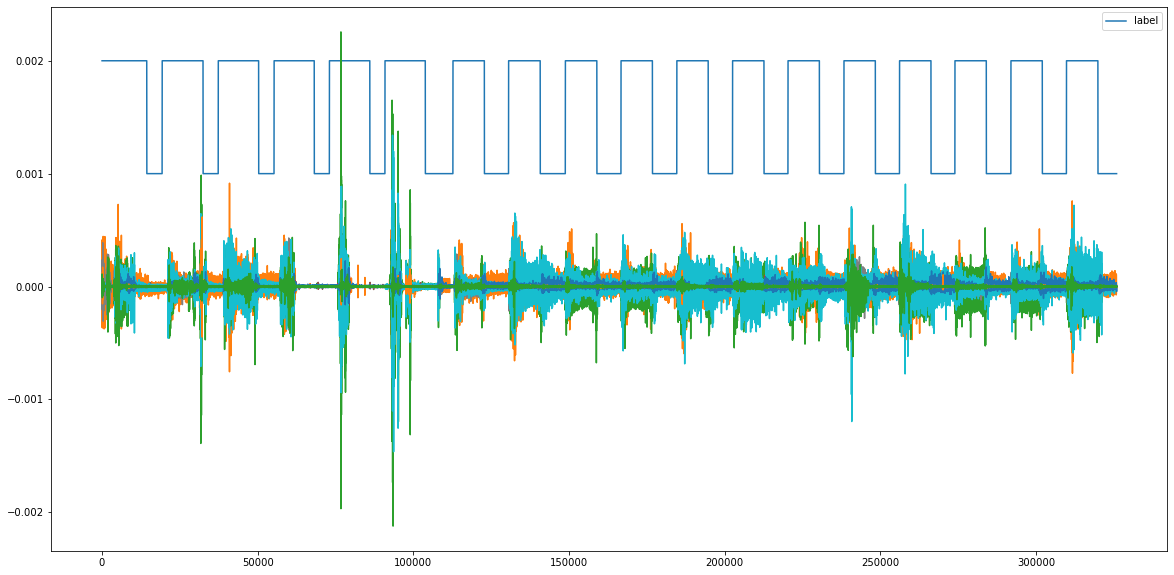

In [30]:
# get the tenth gesture of new signals
s101_rep_inuse_tenth = s101_static.iloc[ten_start_point[9]:ten_end_point[9] + 1,:]

# get the tenth gesture of new labels
label_rep_inuse_tenth = label_static.iloc[ten_start_point[9]:ten_end_point[9] + 1,:]

s101_rep_inuse_tenth = s101_rep_inuse_tenth.reset_index(drop = True)
label_rep_inuse_tenth = label_rep_inuse_tenth.reset_index(drop= True)

index = np.array(s101_rep_inuse_tenth.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_rep_inuse_tenth*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_rep_inuse_tenth[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### find the first rep_inuse-1 repetition as the training set, and the last repetition as the testing set

In [31]:
# for this time, find the new ten start point and ten end point
# find the ten new start point of the 3 repetition
# ten_start_point2 is for the test data set #1
counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point2 = []
for i in label_number:
    for j in tqdm(range(0, len(label_rep_inuse))):
        if label_rep_inuse.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point2.append(j)
        if counter == 10:
            break

In [32]:
# find the ten new end point of the 3 repetition
last = 1
ten_end_point2 = []
label_number = [1,2,3,4,5,6,7,8,9,10]
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point2[j-1], len(label_rep_inuse))):
        current = label_rep_inuse.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == (rep_inuse-1)*2:
            ten_end_point2.append(i)
            break

In [33]:
ten_start_point2
ten_end_point2

[0,
 328982,
 652534,
 975247,
 1309744,
 1634027,
 1957937,
 2284986,
 2616010,
 2941777]

[312879,
 636484,
 959216,
 1293642,
 1617926,
 1941834,
 2268953,
 2599982,
 2925752,
 3251511]

In [34]:
# get trainx (signal)
trainx = s101_rep_inuse.iloc[ten_start_point2[0]:ten_end_point2[0] + 1,:]
for i in range(1,10):
    trainx = trainx.append(s101_rep_inuse.iloc[ten_start_point2[i]:ten_end_point2[i] + 1,:])
trainx = trainx.reset_index(drop = True)
trainx

,0,1,2,3,4,5,6,7,8,9,10,11
0,-5.004000e-07,1.496400e-06,-0.000014,0.000006,-0.000005,9.756200e-07,5.053400e-07,1.868200e-08,-1.901900e-06,3.091300e-05,8.900800e-07,6.521500e-06
1,1.707100e-07,3.342700e-06,-0.000014,0.000003,-0.000008,1.143500e-06,2.687500e-06,1.871000e-08,-1.566300e-06,2.272300e-05,2.568800e-06,4.795300e-06
2,8.418200e-07,4.014000e-06,-0.000013,-0.000003,-0.000008,3.829100e-06,2.519900e-06,1.873700e-08,-3.077100e-06,1.186600e-05,-1.165600e-07,1.684000e-06
3,1.177200e-06,3.211200e-07,-0.000009,-0.000003,-0.000005,4.500500e-06,5.059100e-07,-1.490900e-07,-4.755600e-06,4.418400e-06,-2.466200e-06,-7.056700e-07
4,3.377400e-07,-1.021800e-06,-0.000004,-0.000002,-0.000003,1.143600e-06,-1.508100e-06,1.879300e-08,-3.748700e-06,1.543100e-06,-3.976600e-06,-5.694100e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
3106940,-3.466000e-06,-3.929800e-06,-0.000005,0.000006,0.000003,3.066600e-06,6.261400e-06,-2.439700e-08,-5.624900e-06,3.182200e-06,5.559900e-07,-2.630900e-07
3106941,-2.291700e-06,-1.580000e-06,-0.000012,0.000006,0.000003,3.066800e-06,3.240400e-06,-2.440500e-08,-3.778100e-06,-5.105200e-07,3.879800e-07,4.081000e-07
3106942,-1.621000e-06,4.341600e-07,-0.000017,0.000006,0.000001,3.402700e-06,-7.878500e-07,-2.441300e-08,-9.242100e-07,1.503600e-06,1.227200e-06,1.247300e-06
3106943,-1.789600e-06,1.776900e-06,-0.000017,0.000005,0.000001,2.060100e-06,-2.801900e-06,-2.442100e-08,1.258200e-06,8.385400e-06,1.730500e-06,1.415000e-06


In [35]:
# get trainy (label)
trainy = label_rep_inuse.iloc[ten_start_point2[0]:ten_end_point2[0] + 1,:]
for i in range(1,10):
    trainy = trainy.append(label_rep_inuse.iloc[ten_start_point2[i]:ten_end_point2[i] + 1,:])
trainy = trainy.reset_index(drop = True)
trainy

,0
0,1
1,1
2,1
3,1
4,1
...,...
3106940,0
3106941,0
3106942,0
3106943,0


### plot training set

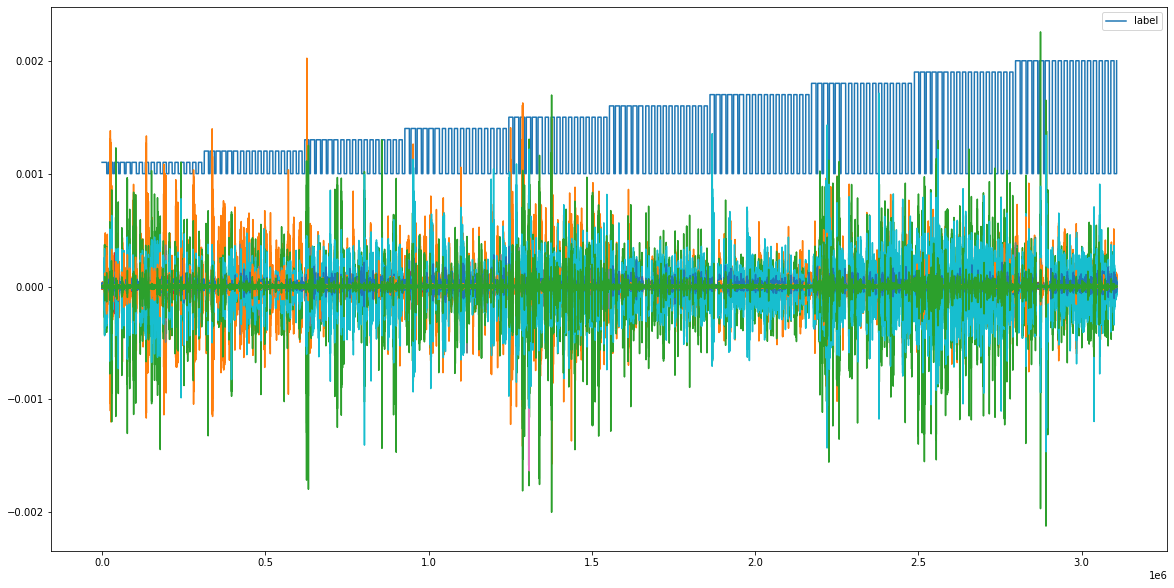

In [36]:
trainx = trainx.reset_index(drop = True)
trainy = trainy.reset_index(drop= True)

index = np.array(trainx.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(trainy*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, trainx[i])
    
line1.set_label('label')
ax.legend()
plt.show()

In [37]:
ten_start_point2
ten_end_point2

[0,
 328982,
 652534,
 975247,
 1309744,
 1634027,
 1957937,
 2284986,
 2616010,
 2941777]

[312879,
 636484,
 959216,
 1293642,
 1617926,
 1941834,
 2268953,
 2599982,
 2925752,
 3251511]

### find the testing set #1

In [38]:
# get testx (signal)
testx1 = s101_rep_inuse.iloc[ten_end_point2[0]:ten_start_point2[1] + 1,:]
for i in range(1,10):
    if i == 9:
        testx1 = testx1.append(s101_rep_inuse.iloc[ten_end_point2[i]:len(trainx),:])
        break
    testx1 = testx1.append(s101_rep_inuse.iloc[ten_end_point2[i]:ten_start_point2[i+1] + 1,:])
    
testx1

,0,1,2,3,4,5,6,7,8,9,10,11
312879,-1.225500e-06,4.004000e-06,-2.007900e-06,-3.362800e-06,1.740500e-06,1.490900e-06,-1.905600e-08,-1.863600e-07,0.000008,-2.672800e-06,-0.000005,-1.723600e-06
312880,1.795600e-06,-3.602700e-07,-4.693600e-06,-3.698500e-06,-6.097000e-07,6.517200e-07,-1.194100e-06,-1.863500e-07,0.000006,-1.777700e-06,-0.000005,-1.220000e-06
312881,3.809700e-06,-4.724600e-06,-6.875800e-06,-4.201900e-06,-1.952800e-06,1.994600e-06,-3.547800e-07,-1.863300e-07,0.000005,-1.867200e-06,-0.000006,-2.562800e-06
312882,2.802500e-06,-6.403300e-06,-7.379400e-06,-2.691300e-06,-7.780700e-07,2.666000e-06,8.201000e-07,-1.863100e-07,0.000005,-2.271300e-06,-0.000004,-2.730500e-06
312883,7.882100e-07,-5.396400e-06,-5.029700e-06,-8.448200e-07,5.644400e-07,-1.698000e-06,3.337900e-06,-1.863000e-07,0.000004,-1.601600e-06,-0.000002,-3.066200e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
2941773,7.023500e-06,6.228400e-06,3.248300e-07,1.893100e-07,3.113800e-06,-4.207200e-06,-1.059500e-05,-7.017900e-08,0.000005,3.761200e-07,-0.000003,-2.744400e-06
2941774,-1.939000e-07,5.725000e-06,1.332000e-06,3.572000e-07,3.953200e-06,-6.053600e-06,-1.160200e-05,-5.722100e-08,0.000021,-1.134400e-06,-0.000003,-5.890000e-08
2941775,-6.068600e-06,3.039500e-06,1.667700e-06,1.028700e-06,4.456800e-06,-8.235700e-06,-1.126600e-05,-5.513500e-08,0.000024,-2.141400e-06,0.000001,1.283700e-06
2941776,-7.746900e-06,1.860800e-07,1.164200e-06,8.609900e-07,3.449800e-06,-8.067900e-06,-1.009200e-05,-7.040500e-08,0.000027,4.060500e-08,0.000002,1.619400e-06


In [39]:
# get testy1 (label)
testy1 = label_rep_inuse.iloc[ten_end_point2[0]:ten_start_point2[1] + 1,:]
for i in range(1,10):
    if i == 9:
        testy1 = testy1.append(label_rep_inuse.iloc[ten_end_point2[i]:len(trainx),:])
        break
    testy1 = testy1.append(label_rep_inuse.iloc[ten_end_point2[i]:ten_start_point2[i+1] + 1,:])
    
testy1

,0
312879,1
312880,1
312881,1
312882,1
312883,1
...,...
2941773,0
2941774,0
2941775,0
2941776,0


### plot testing set #1

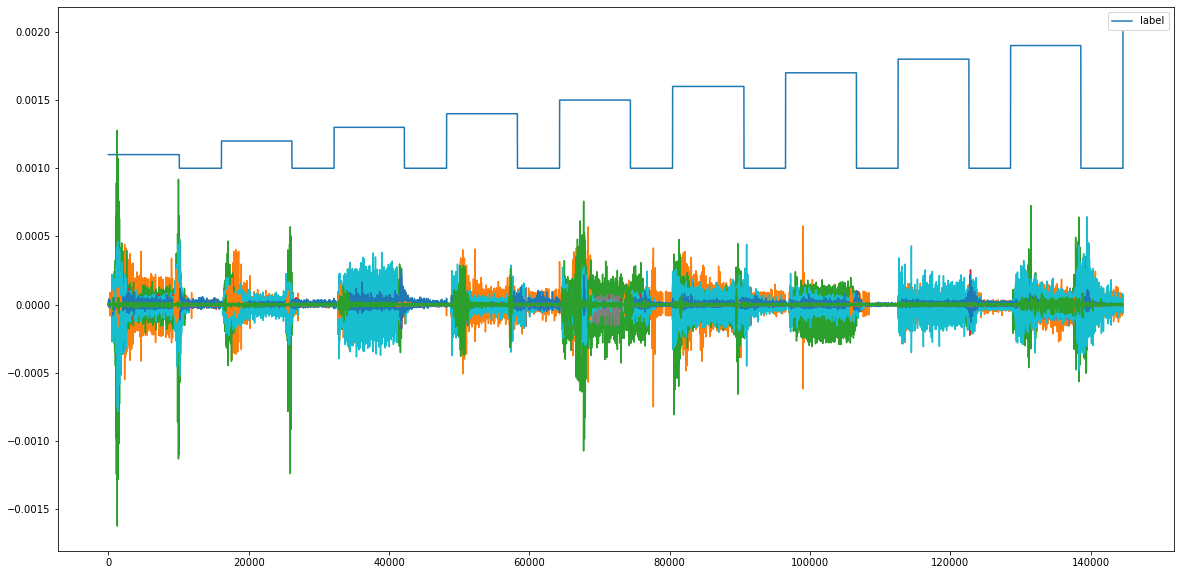

In [40]:
testx1 = testx1.reset_index(drop = True)
testy1 = testy1.reset_index(drop= True)

index = np.array(testx1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy1*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx1[i])
    
line1.set_label('label')
ax.legend()
plt.show()

In [41]:
testy1

,0
0,1
1,1
2,1
3,1
4,1
...,...
144580,0
144581,0
144582,0
144583,0


### find the testing set #2

In [42]:
# find the fisrt 200ms which is 385 data point

# find the ten start point
# ten_start_point3 is for the testing data set #2

counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point3 = []
for i in label_number:
    for j in tqdm(range(0, len(testy1))):
        if testy1.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point3.append(j)
        if counter == 10:
            break

In [46]:
# find the ten new end point
# ten_end_point3 is for the testing data set #2

last = 1
ten_end_point3 = []
label_number = [1,2,3,4,5,6,7,8,9,10]
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point3[j-1], len(testy1))):
        if i == len(testy1)-1:
            ten_end_point3.append(i)
        current = testy1.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == 1:
            ten_end_point3.append(i)
            break

In [47]:
ten_start_point3
ten_end_point3

[0, 16103, 32154, 48186, 64289, 80391, 96495, 112529, 128558, 144584]

[10094, 26143, 42173, 58280, 74382, 90563, 106595, 122626, 138575, 144584]

In [48]:
testx2 = testx1.iloc[ten_start_point3[0]:ten_start_point3[0]+385, :]
testx2 = testx2.append(testx1.iloc[ten_end_point3[0]:ten_end_point3[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testx2 = testx2.append(testx1.iloc[ten_start_point3[i]:ten_start_point3[i]+385, :])
#         testx2 = testx2.append(testx1.iloc[ten_end_point3[i]:220557, :])
#         break
    testx2 = testx2.append(testx1.iloc[ten_start_point3[i]:ten_start_point3[i]+385, :])
    testx2 = testx2.append(testx1.iloc[ten_end_point3[i]:ten_end_point3[i]+385, :])

In [49]:
testy2 = testy1.iloc[ten_start_point3[0]:ten_start_point3[0]+385, :]
testy2 = testy2.append(testy1.iloc[ten_end_point3[0]:ten_end_point3[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testy2 = testy2.append(testy1.iloc[ten_start_point3[i]:ten_start_point3[i]+385, :])
#         testy2 = testy2.append(testy1.iloc[ten_end_point3[i]:220557, :])
#         break
    testy2 = testy2.append(testy1.iloc[ten_start_point3[i]:ten_start_point3[i]+385, :])
    testy2 = testy2.append(testy1.iloc[ten_end_point3[i]:ten_end_point3[i]+385, :])

### plot testing set #2

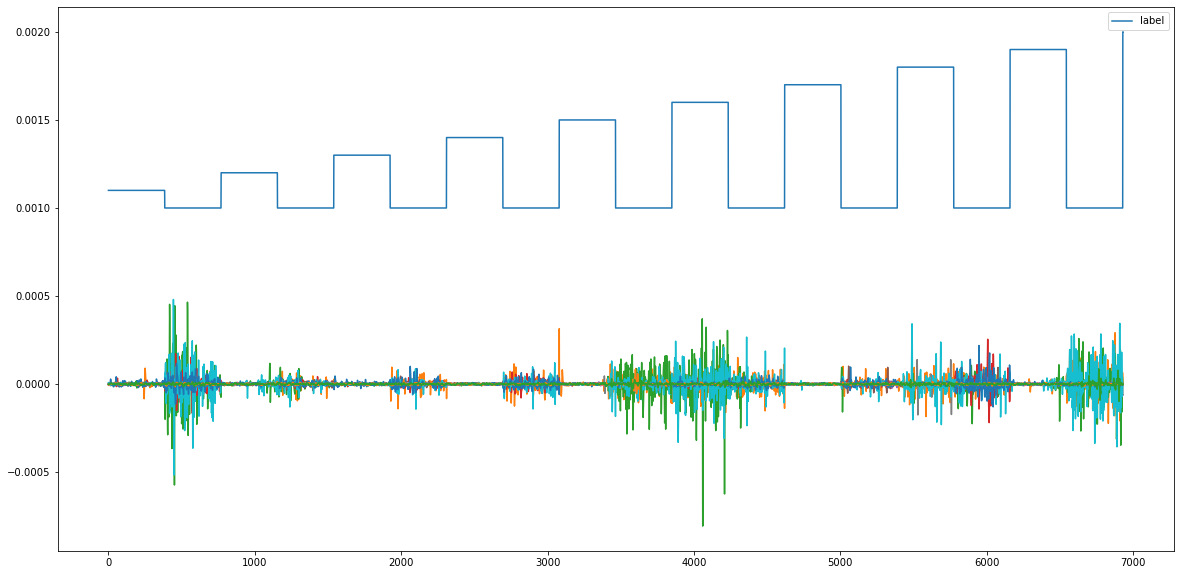

In [50]:
testx2 = testx2.reset_index(drop = True)
testy2 = testy2.reset_index(drop= True)

index = np.array(testx2.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy2*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx2[i])
    
line1.set_label('label')
ax.legend()
plt.show()

## build the model 1

In [ ]:
# svm_model = SVC()
# svm_model.fit(trainx,trainy)

# expected1 = testy1.values.flatten()
# predicted1 = svm_model.predict(testx1)
# expected2 = testy2.values.flatten()
# predicted2 = svm_model.predict(testx2)

### calculate the accuracy

In [ ]:
# counter = 0
# for i in range(0, len(expected1)):
#     if expected1[i] == predicted1[i]:
#         counter += 1

# accuracy1 = counter/len(expected1)

# counter = 0
# for i in range(0, len(expected2)):
#     if expected2[i] == predicted2[i]:
#         counter += 1

# accuracy2 = counter/len(expected2)

### plot two testing results

In [ ]:
# index = np.array(testy1.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted1*0.0001+0.001)
# line2, = ax.plot(expected1*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

# index = np.array(testy2.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted2*0.0001+0.001)
# line2, = ax.plot(expected22*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

## build the model 2

In [51]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

In [52]:
knn_model.fit(trainx,trainy)

<ipython-input-52-afb52ebdfb61>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_model.fit(trainx,trainy)


KNeighborsClassifier()

In [53]:
expected1 = testy1.values.flatten()
predicted1 = knn_model.predict(testx1)

In [54]:
expected2 = testy2.values.flatten()
predicted2 = knn_model.predict(testx2)

In [55]:
expected1
predicted1

array([ 1,  1,  1, ...,  0,  0, 10])

array([ 0,  0,  0, ...,  0, 10,  4])

### calculate the accuracy

In [56]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

In [57]:
counter = 0
for i in range(0, len(expected2)):
    if expected2[i] == predicted2[i]:
        counter += 1

accuracy2 = counter/len(expected2)

In [58]:
accuracy1
accuracy2

0.37461009094996023

0.26745527986151185

### plot two testing results

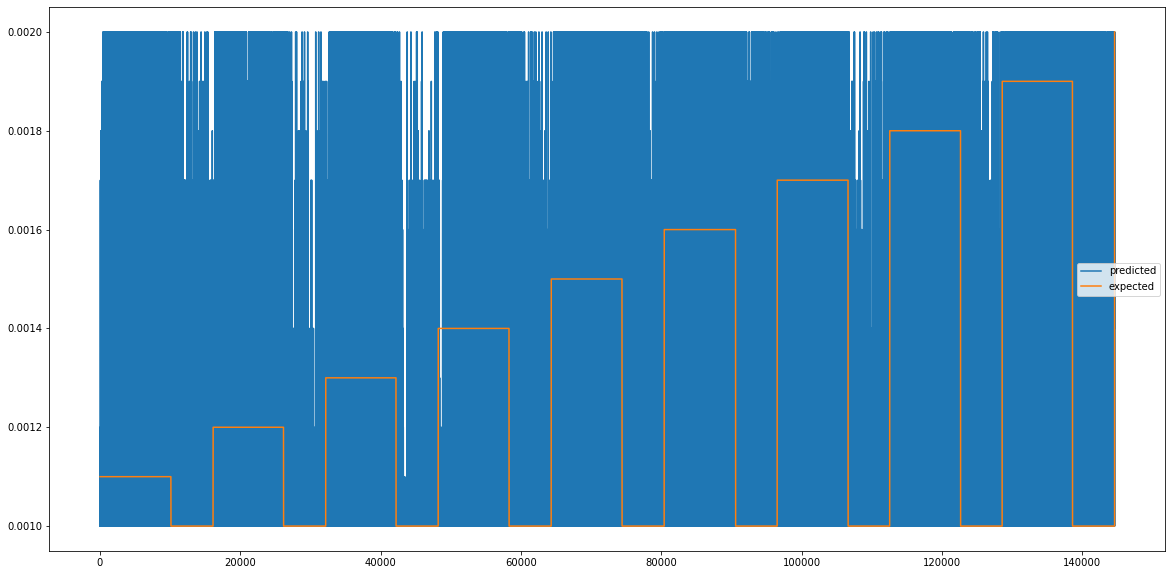

In [59]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

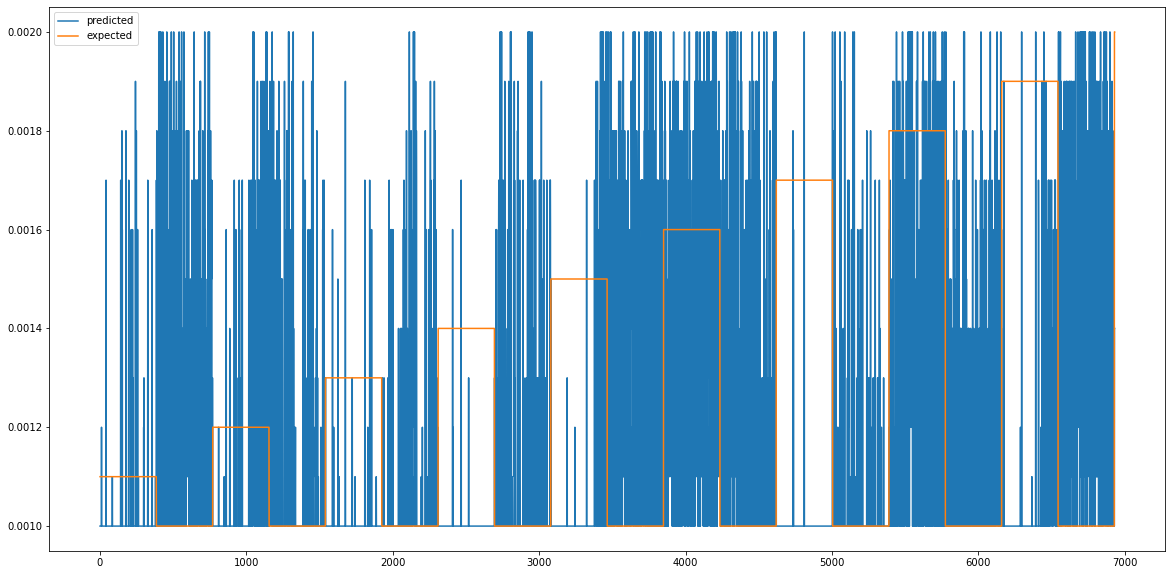

In [60]:
index = np.array(testy2.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted2*0.0001+0.001)
line2, = ax.plot(expected2*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## build the model 3

In [61]:
lightGBM_model = ltb.LGBMClassifier()

In [62]:
lightGBM_model.fit(trainx,trainy)

/Users/shuowang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier()

In [63]:
expected1 = testy1.values.flatten()
predicted1 = lightGBM_model.predict(testx1)

In [64]:
expected2 = testy2.values.flatten()
predicted2 = lightGBM_model.predict(testx2)

In [65]:
expected1
predicted1

array([ 1,  1,  1, ...,  0,  0, 10])

array([0, 0, 0, ..., 0, 0, 0])

### calculate the accuracy

In [66]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

In [67]:
counter = 0
for i in range(0, len(expected2)):
    if expected2[i] == predicted2[i]:
        counter += 1

accuracy2 = counter/len(expected2)

In [68]:
accuracy1
accuracy2

0.41780959297299164

0.3003462204270052

### plot two testing results

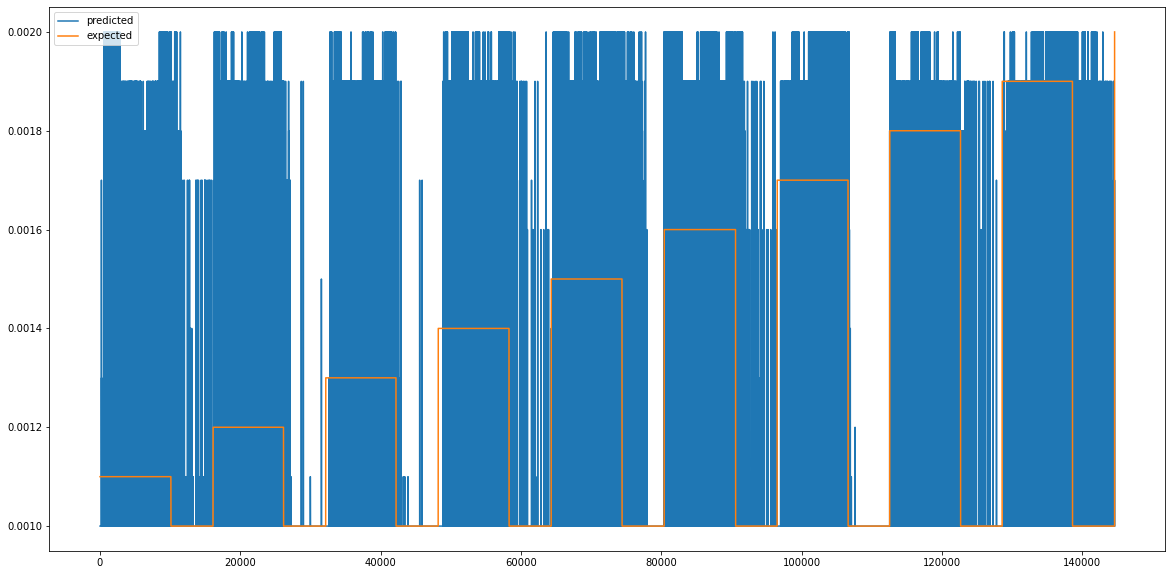

In [69]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

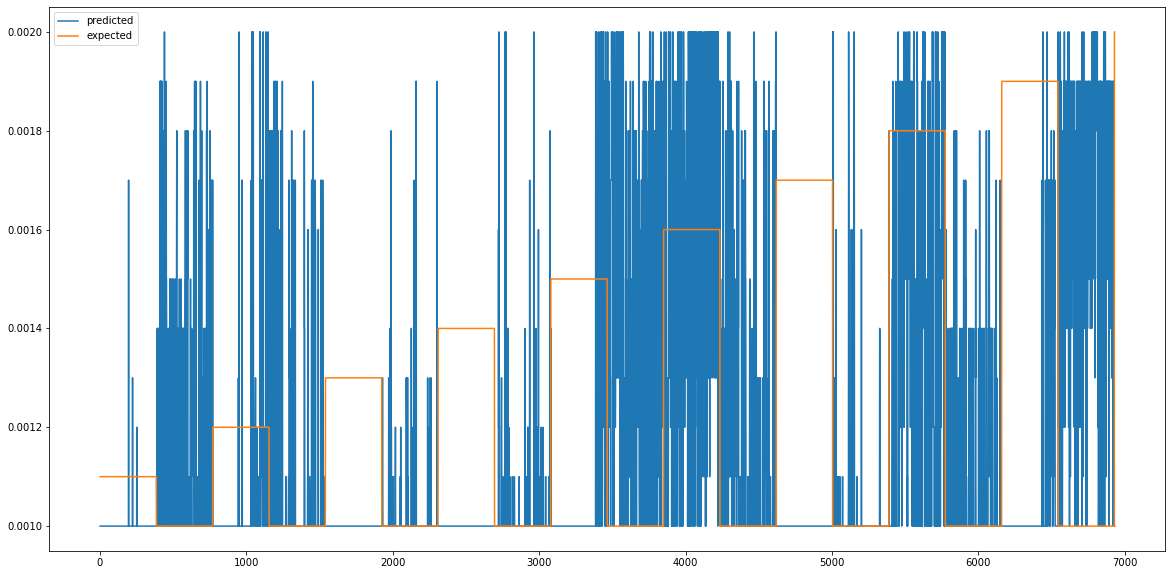

In [70]:
index = np.array(testy2.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted2*0.0001+0.001)
line2, = ax.plot(expected2*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## build the model 4

In [71]:
MLP_model = MLPClassifier(random_state=1, max_iter=300).fit(trainx,trainy)

/Users/shuowang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [72]:
expected1 = testy1.values.flatten()
predicted1 = MLP_model.predict(testx1)

In [73]:
expected2 = testy2.values.flatten()
predicted2 = MLP_model.predict(testx2)

In [74]:
expected1
predicted1

array([ 1,  1,  1, ...,  0,  0, 10])

array([0, 0, 0, ..., 0, 0, 0])

### calculate the accuracy

In [75]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

In [76]:
counter = 0
for i in range(0, len(expected2)):
    if expected2[i] == predicted2[i]:
        counter += 1

accuracy2 = counter/len(expected2)

In [77]:
accuracy1
accuracy2

0.3725006051803437

0.49985574148874784

### plot two testing results

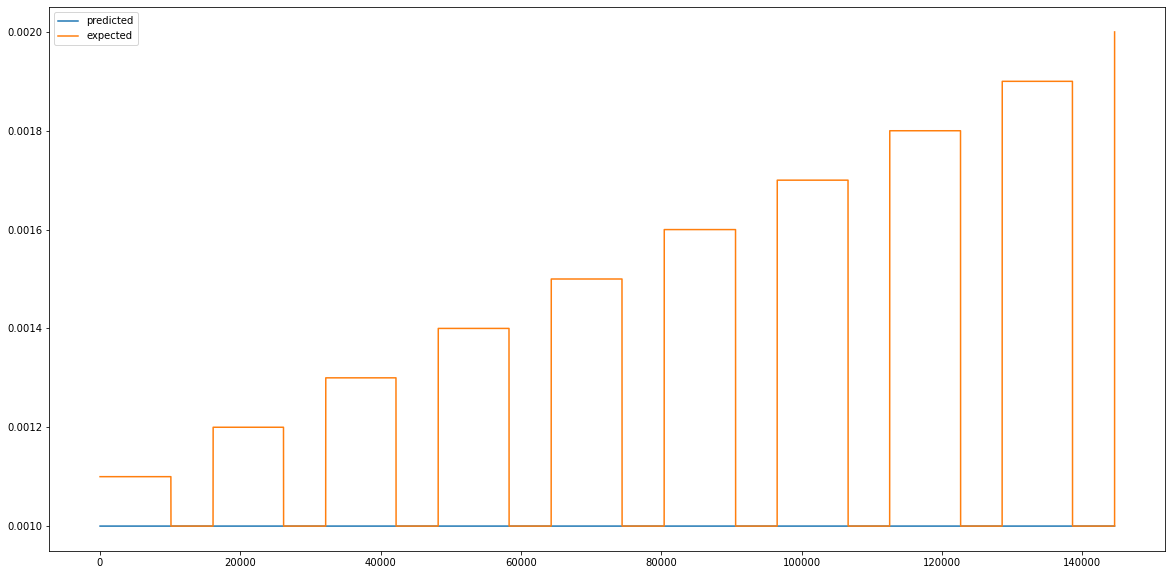

In [78]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

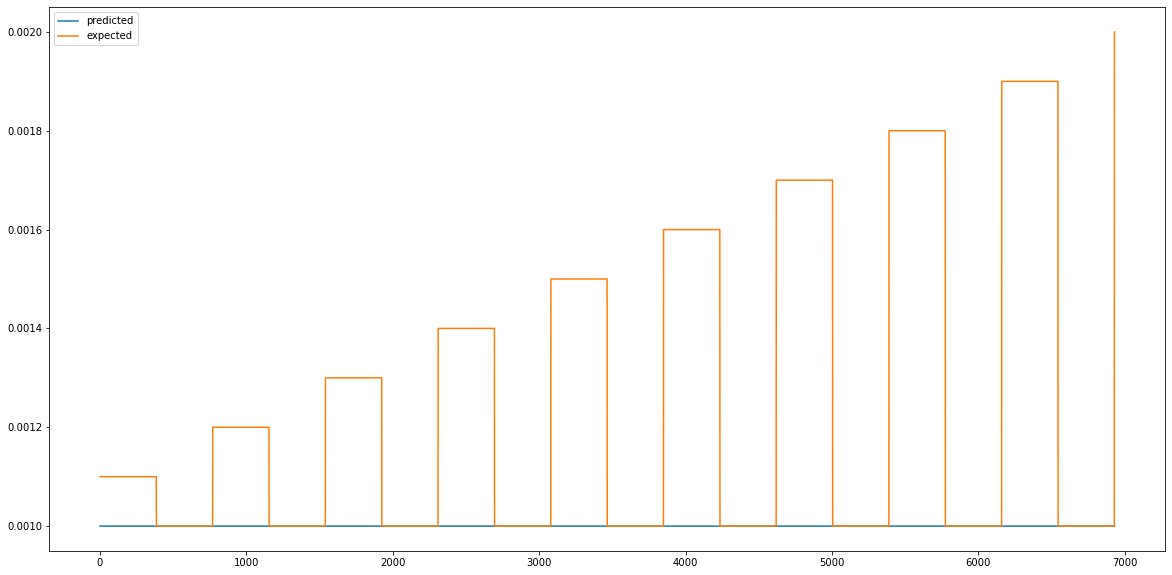

In [79]:
index = np.array(testy2.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted2*0.0001+0.001)
line2, = ax.plot(expected2*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

In [80]:
trainx.to_csv('traintestdata/training_signals.csv')

In [81]:
trainy.to_csv('traintestdata/training_labels.csv')

In [82]:
testx1.to_csv('traintestdata/testing_signals.csv')

In [83]:
testy1.to_csv('traintestdata/testing_labels.csv')